# CODEX analyses

## Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import time
import warnings
import joblib
from pathlib import Path
from time import time
import copy
from skimage import color
import matplotlib as mpl
import napari
import colorcet as cc

from sklearn.preprocessing import StandardScaler
import umap
# if not installed run: conda install -c conda-forge umap-learn
import hdbscan
from sklearn.cluster import OPTICS, cluster_optics_dbscan

from skimage import io

from scipy.stats import ttest_ind    # Welch's t-test
from scipy.stats import mannwhitneyu # Mann-Whitney rank test
from scipy.stats import ks_2samp     # Kolmogorov-Smirnov statistic

from tysserand import tysserand as ty
from mosna import mosna

In [2]:
# If need to reload modules after their modification
from importlib import reload
ty = reload(ty)
mosna = reload(mosna)

In [2]:
data_dir = Path("../data/raw/CODEX_CTCL")
objects_path = data_dir / "41467_2021_26974_MOESM3_ESM_-_Objects.xlsx"

In [3]:
RUN_LONG = False

### Objects data

File that contains all the detected objects (the cells) across all samples.

In [5]:
obj = pd.read_excel(objects_path, skiprows=2)
obj

Count  EventCount  Index in File  ClusterID FileName  ClusterName  \
0            0           1             60      33987   reg001      B cells   
1            1           1             94      33987   reg001      B cells   
2            2           1            198      33987   reg001      B cells   
3            3           1            284      33987   reg001      B cells   
4            4           1            298      33987   reg001      B cells   
...        ...         ...            ...        ...      ...          ...   
117165  116917           1            633      33981   reg066  vasculature   
117166  116918           1            677      33981   reg066  vasculature   
117167  116919           1            681      33981   reg066  vasculature   
117168  116920           1            705      33981   reg066  vasculature   
117169  116921           1            711      33981   reg066  vasculature   

        Spots  Patients  Groups      FOXP3  ...  PD-1+CD8+  CD4+Tcells  \
0           1         1       1   0.692403  ...          0           0   
1           1         1       1   8.094747  ...          0           0   
2           1         1       1   4.110389  ...          0           0   
3           1         1       1   0.000000  ...          0           0   
4           1         1       1   2.937673  ...          0           0   
...       ...       ...     ...        ...  ...        ...         ...   
117165     66        14       4  84.269714  ...          0           0   
117166     66        14       4  56.425945  ...          0           0   
117167     66        14       4  63.152092  ...          0           0   
117168     66        14       4  66.873306  ...          0           0   
117169     66        14       4  17.966373  ...          0           0   

        PD-1+tumor  CD8+Tcells  Ki67+CD4+  Ki-67+Tregs  ICOS+Tregs  IDO+Tregs  \
0                0           0          0            0           0          0   
1                0           0          0            0           0          0   
2                0           0          0            0           0          0   
3                0           0          0            0           0          0   
4                0           0          0            0           0          0   
...            ...         ...        ...          ...         ...        ...   
117165           0           0          0            0           0          0   
117166           0           0          0            0           0          0   
117167           0           0          0            0           0          0   
117168           0           0          0            0           0          0   
117169           0           0          0            0           0          0   

        Ki67+tumor  original_index  
0                0               0  
1                0               1  
2                0               2  
3                0               3  
4                0               4  
...            ...             ...  
117165           0          116917  
117166           0          116918  
117167           0          116919  
117168           0          116920  
117169           0          116921  

[117170 rows x 121 columns]

In [6]:
# sample_cols = obj.columns[:10]
obj.rename(columns={'X': 'x', 'Y': 'y', 'Z':'z'}, inplace=True)
sample_cols = ['FileName', 'ClusterName', 'Patients', 'Spots' ,'Groups']
marker_cols = obj.columns[9:67]
marker_cols = [x for x in marker_cols if x != 'HOECHST1:Cyc_1_ch_1']
# cell_pos_cols = obj.columns[69:76]
cell_pos_cols = ['x', 'y', 'z']#	size]
# cell_type_cols = obj.columns[76:101]
cell_type_cols = list(obj.columns[75:96])
marker_posit_cols = list(obj.columns[100:-1])
all_cols = sample_cols + marker_cols + cell_pos_cols + cell_type_cols + marker_posit_cols
nb_clusters = obj['ClusterName'].unique().size

In [7]:
obj.shape

(117170, 121)

In [8]:
obj[['FileName', 'Patients', 'Count']].groupby(['Patients', 'FileName']).count()

Count
Patients FileName       
1        reg001     1301
         reg002     2324
         reg003     1145
         reg004      745
2        reg005      112
...                  ...
14       reg062     3696
         reg063     3610
         reg064     4163
         reg065     1238
         reg066      792

[69 rows x 1 columns]

### Response status pre/post treatment

In [9]:
code_groups = {
  1: 'Responder, pre-treatment',
  2: 'Non-responder, pre-treatment',
  3: 'Responder, post-treatment',
  4: 'Non-responder, post-treatment',
} 

In [10]:
status_path = data_dir / "41467_2021_26974_MOESM5_ESM - Patients_spots_conditons.xlsx"
status = pd.read_excel(status_path, skiprows=2, usecols=['Patients', 'Groups', 'Spots'])
status

Patients  Groups  Spots
0         10       1     39
1         11       3     43
2         11       1     41
3         11       1     42
4         12       4     47
..       ...     ...    ...
59         8       2     31
60         9       3     38
61         9       3     67
62         9       3     68
63         9       1     35

[64 rows x 3 columns]

In [11]:
np.sort(obj['FileName'].unique())
# reg044 is missing

array(['reg001', 'reg002', 'reg003', 'reg004', 'reg005', 'reg006',
       'reg007', 'reg008', 'reg009', 'reg010', 'reg011', 'reg012',
       'reg013', 'reg014', 'reg015', 'reg016', 'reg017', 'reg018',
       'reg019', 'reg020', 'reg021', 'reg022', 'reg023', 'reg024',
       'reg025', 'reg026', 'reg027', 'reg028', 'reg029', 'reg030',
       'reg031', 'reg032', 'reg033', 'reg034', 'reg035', 'reg036',
       'reg037', 'reg038', 'reg039', 'reg040', 'reg041', 'reg042',
       'reg043', 'reg045', 'reg046', 'reg047', 'reg048', 'reg049',
       'reg050', 'reg051', 'reg052', 'reg053', 'reg054', 'reg055',
       'reg056', 'reg057', 'reg058', 'reg059', 'reg060', 'reg061',
       'reg062', 'reg063', 'reg064', 'reg065', 'reg066', 'reg067',
       'reg068', 'reg069', 'reg070'], dtype=object)

In [12]:
status['Spots'].sort_values().values

array([ 1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38,
       39, 41, 42, 43, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70])

### Survival data

In [16]:
survival_path = data_dir / "cohort_response.ods"
surv = pd.read_excel(survival_path)
surv.index = surv['Patient ID']
surv.drop(columns=['Patient ID'], inplace=True)
# surv.index.name = 'sample'
surv

Age at screening (years)  Gender Diagnosis Disease Stage  \
Patient ID                                                             
1                              76.14    Male        MF          IIIA   
2                              60.59    Male        MF          IIIB   
3                              52.01    Male        SS           IVA   
4                              85.14  Female        SS           IVA   
5                              75.24    Male        MF           IIB   
6                              46.74    Male        MF           IVA   
7                              46.71  Female        MF          IIIB   
8                              67.44    Male        SS          IIIB   
9                              77.65  Female        SS           IVA   
10                             66.40    Male        MF          IIIA   
11                             72.23    Male        SS           IVA   
12                             72.59    Male        SS           IVA   
13                             44.10  Female        SS           IVA   
14                             63.69    Male        MF            IB   

            Prior therapies Response status        Biopsy timepoints  \
Patient ID                                                             
1                         3       Responder                 Pre, EOT   
2                         4       Responder                 Pre, EOT   
3                         3   Non-responder                 Pre, EOT   
4                         4   Non-responder                 Pre, EOT   
5                         6       Responder                 Pre, EOT   
6                         9   Non-responder            Pre, CO2, EOT   
7                         3   Non-responder                 Pre, EOT   
8                         1   Non-responder                 Pre, EOT   
9                         6       Responder            Pre, CO2, EOT   
10                        2       Responder                      Pre   
11                        3       Responder            Pre, Response   
12                        5   Non-responder         Pre, Progression   
13                        1       Responder  Pre, CO2, Response, EOT   
14                        5   Non-responder  Pre, CO2, Response, EOT   

            CO2 (weeks)  Response / progression time (weeks)  \
Patient ID                                                     
1                   NaN                                  NaN   
2                   NaN                                  NaN   
3                   NaN                                  NaN   
4                   NaN                                  NaN   
5                   NaN                                  NaN   
6                   3.0                                  NaN   
7                   NaN                                  NaN   
8                   NaN                                  NaN   
9                   3.0                                  NaN   
10                  NaN                                  NaN   
11                  NaN                                 22.0   
12                  NaN                                 15.0   
13                  3.0                                 15.0   
14                  3.0                                 10.0   

            EOT time (weeks)  Death time (weeks)  Follow-up time (weeks)  
Patient ID                                                                
1                      104.0                 NaN                     142  
2                      104.0                 NaN                     151  
3                       98.0                98.0                      98  
4                      104.0               142.0                     142  
5                      104.0                 NaN                     103  
6                       25.0                 NaN                      25  
7                        9.0                 NaN                       9  
8     

## Spatial networks reconstruction

### Load samples of one patient

We will have a look at the spatial networks of the 4 samples of the first patient to check they seem "correct", i.e. not over nor under connected.

processing filename reg001
all nodes have at least one edge
processing filename reg002
there are 1/2324 nodes with no edges
processing filename reg003
there are 1/1145 nodes with no edges
processing filename reg004
all nodes have at least one edge


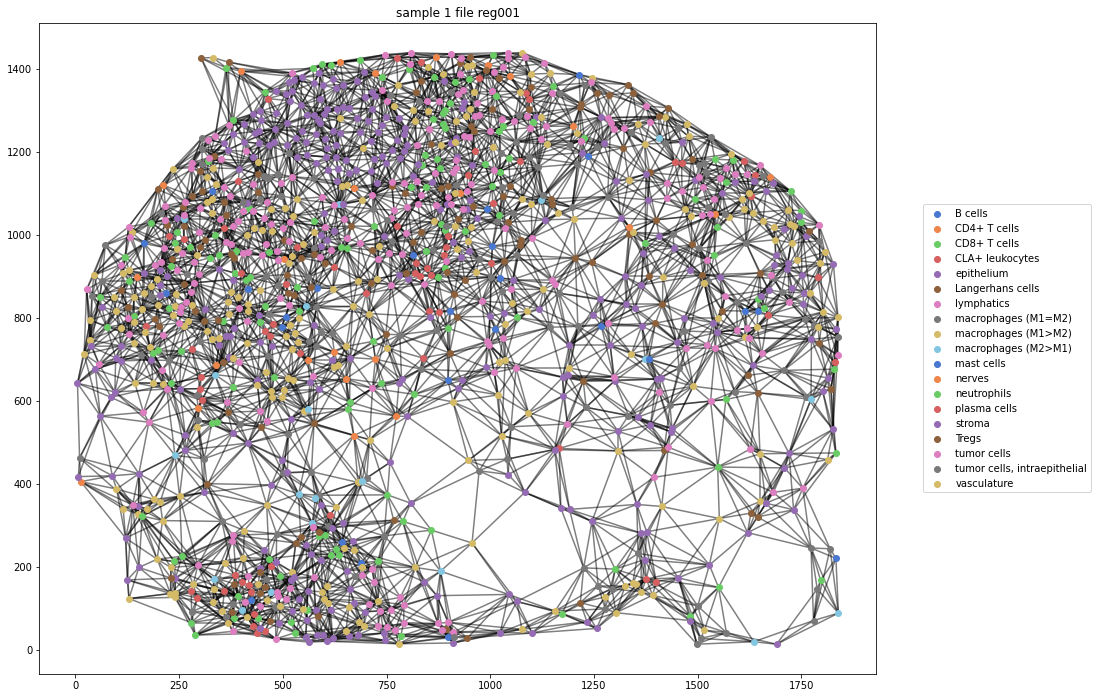

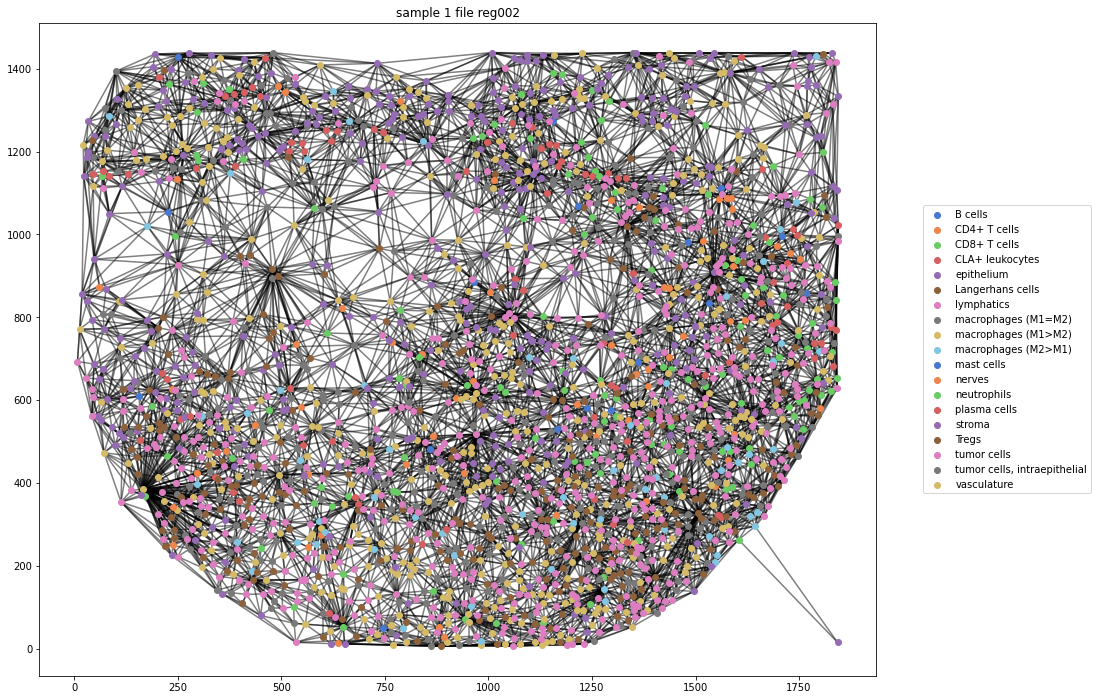

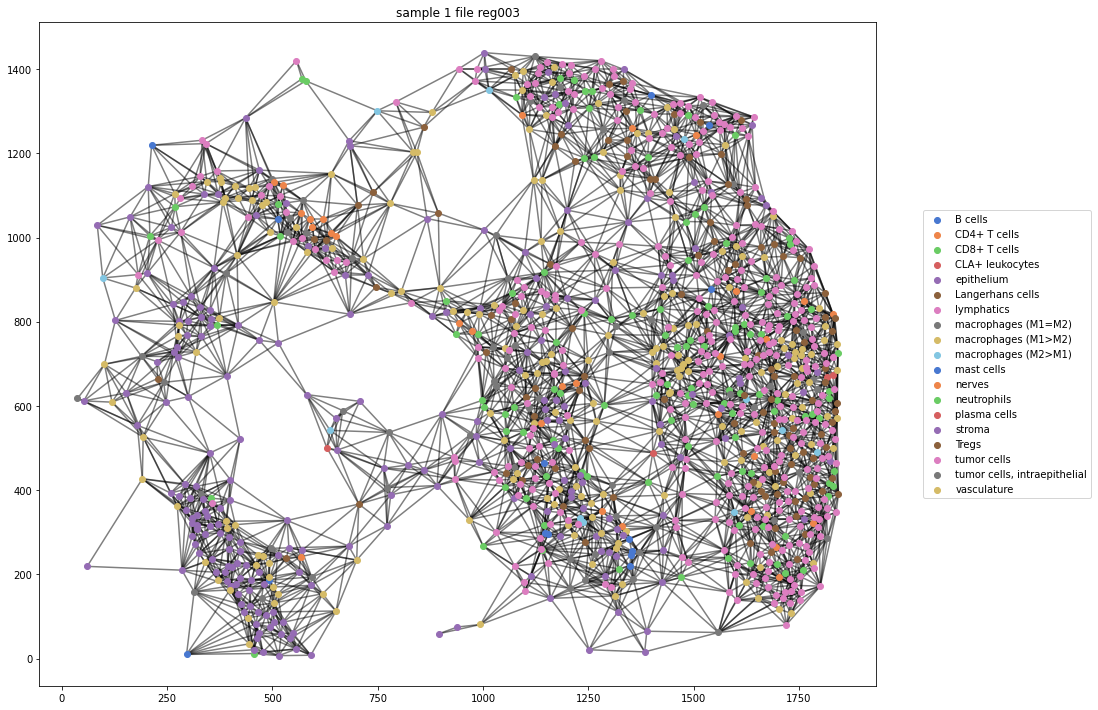

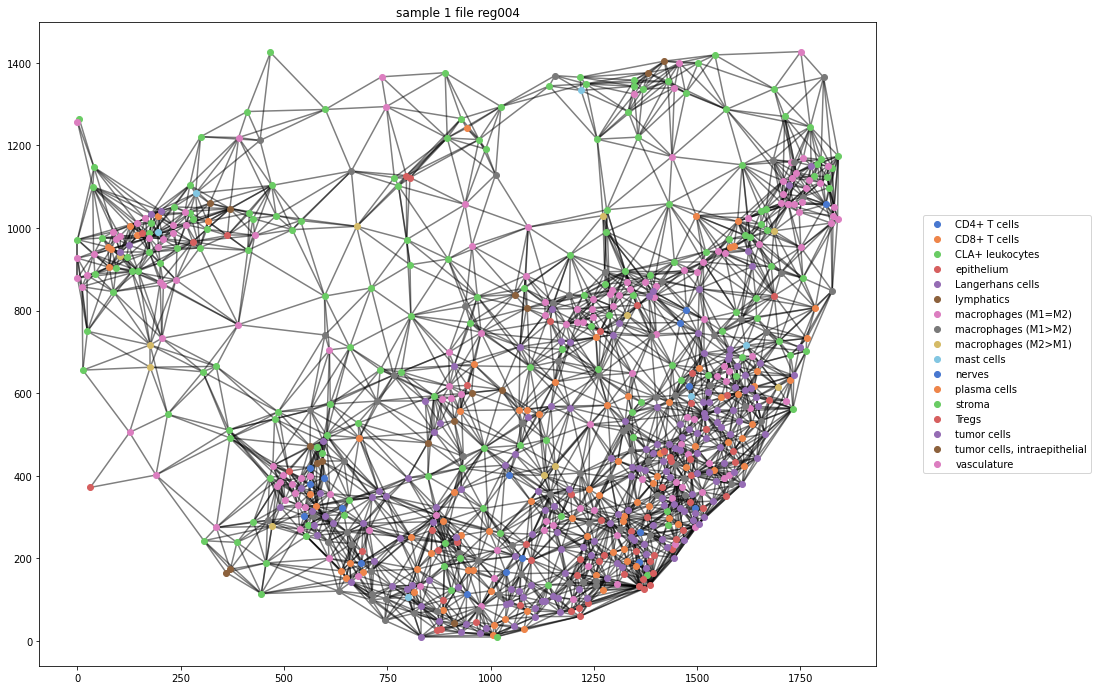

In [12]:
sample_id = 1  # that's our patient
select_sample = obj['Patients'] == sample_id
filenames = obj.loc[select_sample, 'FileName'].unique()  # look for the several samples per patient
for filename in filenames:
    print("processing filename {}".format(filename))
    select_file = obj['FileName'] == filename
    nodes = obj.loc[select_sample & select_file, all_cols]
    coords = nodes[['x', 'y', 'z']].values
    pairs = ty.build_delaunay(coords)
    # we want to avoid isolated cells, so we link them to their 2 closest neighbors
    pairs = ty.link_solitaries(coords, pairs, method='knn', k=2)

    fig, ax = ty.plot_network(coords[:, :-1], pairs, labels=nodes['ClusterName'],
                              legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
    plt.title("sample {} file {}".format(sample_id, filename))

### All samples network reconstruction

#### Plot spatial networks

In [17]:
processed_dir = Path('../data/processed/CODEX_CTCL')
save_dir = processed_dir / "all_samples_networks"

In [18]:
k_sol = 2  # link isolated nodes to 2 closest neighbors

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

if RUN_LONG:
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[['x', 'y', 'z']].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            fig, ax = ty.plot_network(coords[:, :-1], pairs, labels=nodes['ClusterName'],
                                    legend_opt={'loc': 'center left', 'bbox_to_anchor': (1.05, 0.5)})
            plt.axis('off');
            title = f"sample-{sample_id}_filename-{filename}_network_delaunay"
            plt.savefig(str(save_dir / title) + '.png', bbox_inches='tight', facecolor='white')
            plt.show()

#### Merge all samples

In [19]:
if RUN_LONG:
    edges_all = pd.DataFrame(data=None, columns=['source', 'target'])
    # number of nodes previously seen
    nb_nodes = 0
    for sample_id in obj['Patients'].unique():
        print(f"processing sample {sample_id}")
        select_sample = obj['Patients'] == sample_id
        filenames = obj.loc[select_sample, 'FileName'].unique()
        for filename in filenames:
            print("    processing filename {}".format(filename))
            select_file = obj['FileName'] == filename
            nodes = obj.loc[select_sample & select_file, all_cols]
            coords = nodes[['x', 'y', 'z']].values
            pairs = ty.build_delaunay(coords)
            print("    ", end="")
            pairs = ty.link_solitaries(coords, pairs, method='knn', k=k_sol)

            # increase ids in pairs by the number of nodes in all previously loaded networks
            pairs = pairs + nb_nodes
            edges = pd.DataFrame(data=pairs, columns=['source', 'target'])
            # update number of nodes for next network
            nb_nodes = nb_nodes + coords.shape[0]
            edges_all = pd.concat([edges_all, edges], ignore_index=True)
    edges_all.to_csv(save_dir / 'sample_all-edges.csv', index=False)
else:
    edges_all = pd.read_csv(save_dir / 'sample_all-edges.csv')

## Response groups characteristics and survival analysis

We will look at what variables define or explain response to therapy or longer survival.  
For this, we will start with the simplest statistics, like proportions of cell types or marker-positive cells, and we will gradulally increase the complexity of variables, looking at interactions between cell types and finally discovering spatial neighborhoods, potentially predictive of response to therapy.

### Cell types proportions

In [20]:
# we add attributes to nodes to color network figures
nodes_all = obj[['x', 'y', 'z']].copy()
nodes_all['CellCluster'] = obj['ClusterName'].values
nodes_all = nodes_all.join(pd.get_dummies(obj['ClusterName']))
attribute_uniq = nodes_all['CellCluster'].unique()

In [21]:
# here we don't use `FileName` in the group / unstack procedure to aggregate statistics 
# per patient and condition (before / after treatment) rather than per sample.

count_types = obj[['Patients', 'Groups', 'Count']].join(nodes_all['CellCluster']).groupby(['Patients', 'Groups', 'CellCluster']).count().unstack()
count_types.columns = count_types.columns.droplevel()
count_types = count_types.fillna(value=0).astype(int)
# count_types.index.name = 'sample'
count_types.to_csv(save_dir / 'count_types_per_patient_per_condition.csv')
count_types.head(6)

CellCluster      B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                         
1        1            34            50           229               20   
         3             3            23           191                7   
2        1             6             3             5                3   
         3            79            29            18                0   
3        2             2           208           186               14   
         4             0            63           192                8   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells  Tregs  \
Patients Groups                                                             
1        1                 0                   0                42    350   
         3                 0                   0                15    160   
2        1                 0                   0                12     15   
         3                 0                   0                13     76   
3        2                 0                   2               130     99   
         4                 0                   8                63    157   

CellCluster      epithelium  lymphatics  ...  macrophages (M1>M2)  \
Patients Groups                          ...                        
1        1              112          23  ...                  545   
         3               72          30  ...                  201   
2        1                6           5  ...                   71   
         3              259           0  ...                  265   
3        2             1759          24  ...                  397   
         4             2299           0  ...                  295   

CellCluster      macrophages (M2>M1)  mast cells  nerves  neutrophils  \
Patients Groups                                                         
1        1                        83           9      33           36   
         3                        22          17      24            2   
2        1                        64           3       6            1   
         3                       146          11      12            0   
3        2                        39          33      17            0   
         4                        43           8       6            0   

CellCluster      plasma cells  stroma  tumor cells  \
Patients Groups                                      
1        1                133     582          777   
         3                  4     317          527   
2        1                  4     203          155   
         3                 12     396         2900   
3        2                  4     328          546   
         4                  1     278          428   

CellCluster      tumor cells, intraepithelial  vasculature  
Patients Groups                                             
1        1                                 48          149  
         3                                  3          143  
2        1                                  2           95  
         3                                  0          166  
3        2                                274           86  
         4                                320          111  

[6 rows x 21 columns]

Instead of counts we use proportions of cell types per patient and condition.

In [22]:
prop_types = count_types.div(count_types.sum(axis=1), axis=0)
prop_types

CellCluster       B cells  CD4+ T cells  CD8+ T cells  CLA+ leukocytes  \
Patients Groups                                                          
1        1       0.009379      0.013793      0.063172         0.005517   
         3       0.001587      0.012169      0.101058         0.003704   
2        1       0.008392      0.004196      0.006993         0.004196   
         3       0.016982      0.006234      0.003869         0.000000   
3        2       0.000465      0.048327      0.043216         0.003253   
         4       0.000000      0.014041      0.042790         0.001783   
4        2       0.058649      0.006590      0.014827         0.000000   
         4       0.004557      0.013671      0.074623         0.000570   
5        1       0.000000      0.000000      0.000984         0.000000   
         3       0.000929      0.013928      0.005571         0.002786   
6        2       0.017263      0.041597      0.144135         0.003120   
         4       0.013105      0.008403      0.056923         0.001401   
7        2       0.000000      0.000000      0.000000         0.000000   
         4       0.004601      0.003067      0.013804         0.000000   
8        2       0.004871      0.008524      0.007916         0.002841   
         4       0.008799      0.004969      0.048551         0.003209   
9        1       0.000749      0.007113      0.019094         0.000749   
         3       0.005252      0.041900      0.079026         0.001910   
10       1       0.002754      0.005507      0.028718         0.000000   
11       1       0.001342      0.006711      0.014765         0.000000   
         3       0.004415      0.002208      0.006623         0.002208   
12       2       0.005878      0.018001      0.039309         0.001837   
         4       0.002824      0.016590      0.022238         0.001765   
13       1       0.001793      0.013625      0.005737         0.002510   
         3       0.081141      0.014507      0.042660         0.001967   
14       2       0.004636      0.014238      0.034437         0.002318   
         4       0.034213      0.005217      0.042253         0.001197   

CellCluster      DCs, CD11c+  IDO+ stromal cells  Langerhans cells     Tregs  \
Patients Groups                                                                
1        1          0.000000            0.000000          0.011586  0.096552   
         3          0.000000            0.000000          0.007937  0.084656   
2        1          0.000000            0.000000          0.016783  0.020979   
         3          0.000000            0.000000          0.002794  0.016337   
3        2          0.000000            0.000465          0.030204  0.023002   
         4          0.000000            0.001783          0.014041  0.034990   
4        2          0.000000            0.000000          0.005272  0.002965   
         4          0.000570            0.000000          0.001709  0.057818   
5        1          0.000000            0.000000          0.004921  0.005906   
         3          0.000000            0.000000          0.011142  0.047354   
6        2          0.000000            0.000624          0.019759  0.074251   
         4          0.000000            0.000100          0.026511  0.105342   
7        2          0.000000            0.000000          0.002494  0.000000   
         4          0.000000            0.000000          0.004601  0.015337   
8        2          0.000000            0.000000          0.001827  0.007713   
         4          0.018116            0.001035          0.003520  0.010973   
9        1          0.000000            0.000000          0.004118  0.003370   
         3          0.000477            0.015280          0.000955  0.010386   
10       1          0.000000            0.000000          0.007081  0.042486   
11       1          0.000671            0.000000          0.014765  0.053691   
         3          0.000000            0.000000          0.000000  0.019868   
12       2   

#### Descriptive statistics

In [17]:
pvals = mosna.find_DE_markers(prop_types, group_ref=1, group_tgt=2, group_var='Groups', composed_vars=False)
pvals = pvals.sort_values(by='pval', ascending=True)
pvals

pval  pval_corr
CellCluster                                      
macrophages (M1=M2)           0.212121   0.999961
CD4+ T cells                  0.212121   0.999961
tumor cells                   0.575175   0.999961
macrophages (M2>M1)           0.575175   0.999961
lymphatics                    0.575175   0.999961
Langerhans cells              0.575175   0.999961
B cells                       0.575175   0.999961
CD8+ T cells                  0.575175   0.999961
IDO+ stromal cells            0.575175   0.999961
vasculature                   0.575175   0.999961
Tregs                         0.962704   0.999961
epithelium                    0.962704   0.999961
tumor cells, intraepithelial  0.962704   0.999961
macrophages (M1>M2)           0.962704   0.999961
CLA+ leukocytes               0.962704   0.999961
nerves                        0.962704   0.999961
neutrophils                   0.962704   0.999961
stroma                        0.962704   0.999961
DCs, CD11c+                   0.999961   0.999961
mast cells                    0.999961   0.999961
plasma cells                  0.999961   0.999961

Cell types proportions are not significantly associated with response / non response in samples before treatment.  
But `mosna` can find composed variables potentially related to response of patients:

In [18]:
# `find_DE_markers` can make composite variables, but we do it beforehand to reuse them
prop_types_comp = pd.concat([prop_types, mosna.make_composed_variables(prop_types, order=2)], axis=1)

pvals = mosna.find_DE_markers(prop_types_comp, group_ref=1, group_tgt=2, group_var='Groups')
pvals = pvals.sort_values(by='pval', ascending=True)

In [19]:
pvals.head(20)

pval  pval_corr
((lymphatics / macrophages (M1=M2)) / (macropha...  0.000583        1.0
((CD8+ T cells / nerves) / (Tregs / tumor cells))   0.008159        1.0
((lymphatics / macrophages (M1>M2)) / (stroma /...  0.008159        1.0
((lymphatics / tumor cells) / (macrophages (M1=...  0.008159        1.0
(lymphatics / macrophages (M1=M2))                  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((lymphatics / stroma) / (stroma / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (macropha...  0.008159        1.0
((macrophages (M1=M2) / macrophages (M1>M2)) / ...  0.008159        1.0
((B cells / macrophages (M2>M1)) / (nerves / tu...  0.008159        1.0
((lymphatics / stroma) / (nerves / tumor cells))    0.008159        1.0
((lymphatics / macrophages (M2>M1)) / (mast cel...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M2>M1) /...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1>M2) /...  0.008159        1.0
((CD4+ T cells / stroma) / (Tregs / lymphatics))    0.008159        1.0
((epithelium / nerves) / (epithelium / tumor ce...  0.008159        1.0
((macrophages (M1>M2) / vasculature) / (macroph...  0.008159        1.0
((lymphatics / stroma) / (macrophages (M1=M2) /...  0.008159        1.0
((CD4+ T cells / nerves) / (mast cells / tumor ...  0.008159        1.0

The first variables related to cell types proportions are composed variables of the 2nd order (ratio of ratios), only `lymphatics / macrophages (M1=M2)` appear in the simpler composed variables, but all corrected pvalues are > 0.05. This is because mosna produced *a lot* of composed variables.

#### Visualization

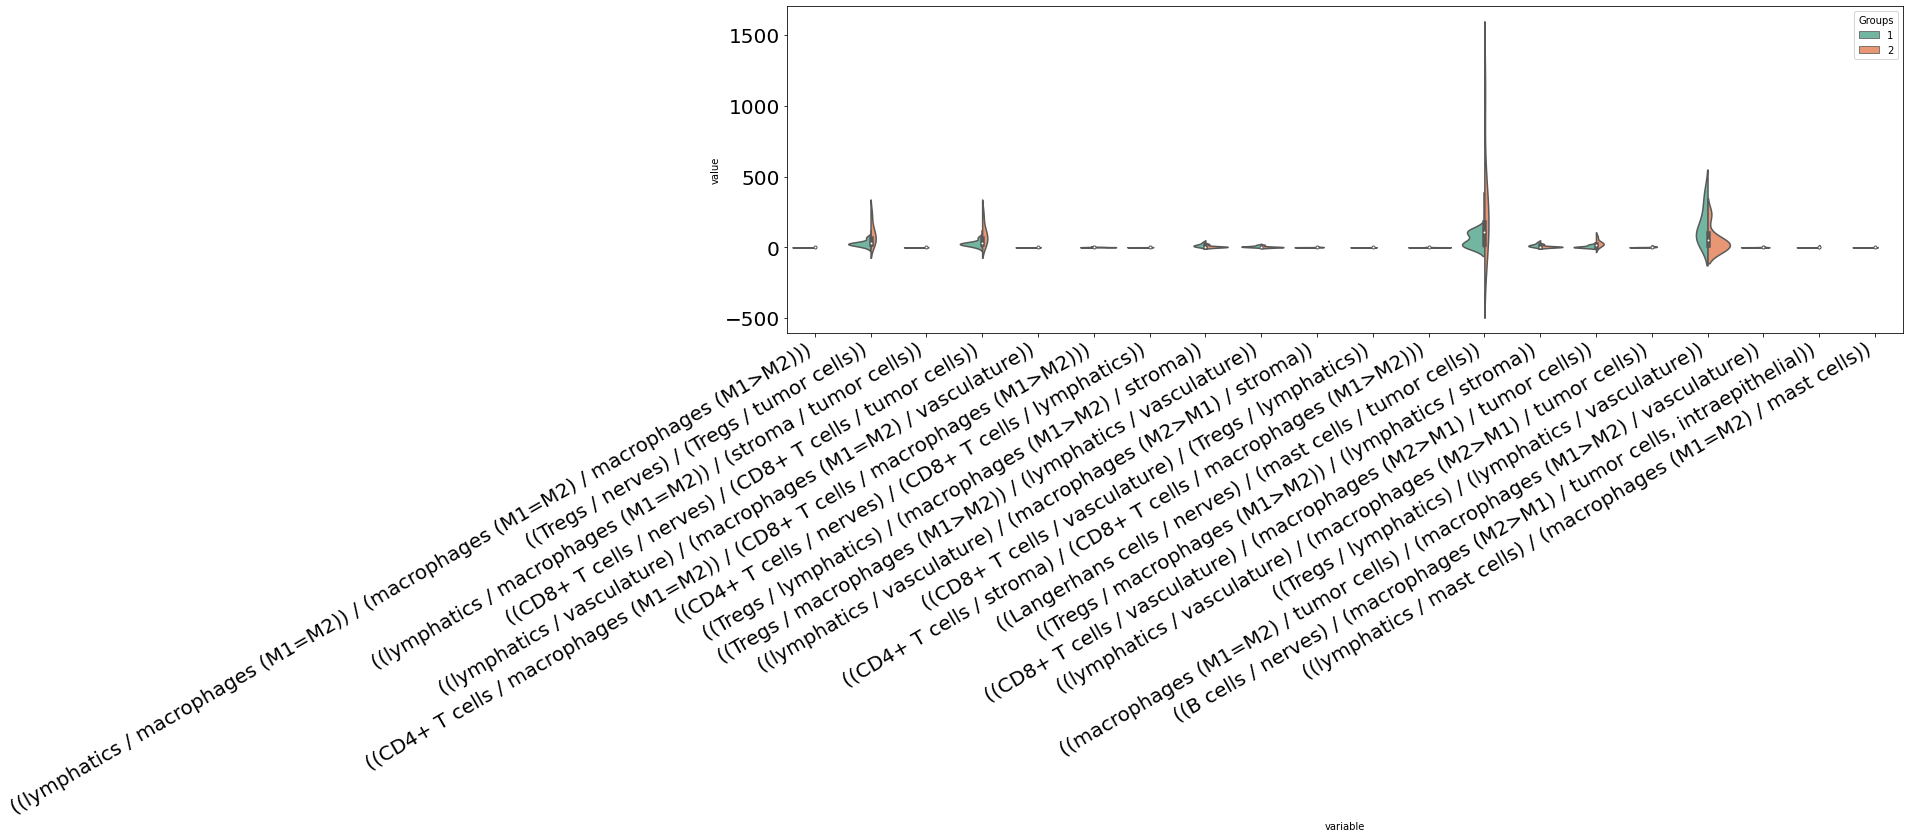

In [20]:
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    groups_labels='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    )

Some variables hide the distribution of other variables by their much larger range, we can exclude them to better see the other variables:

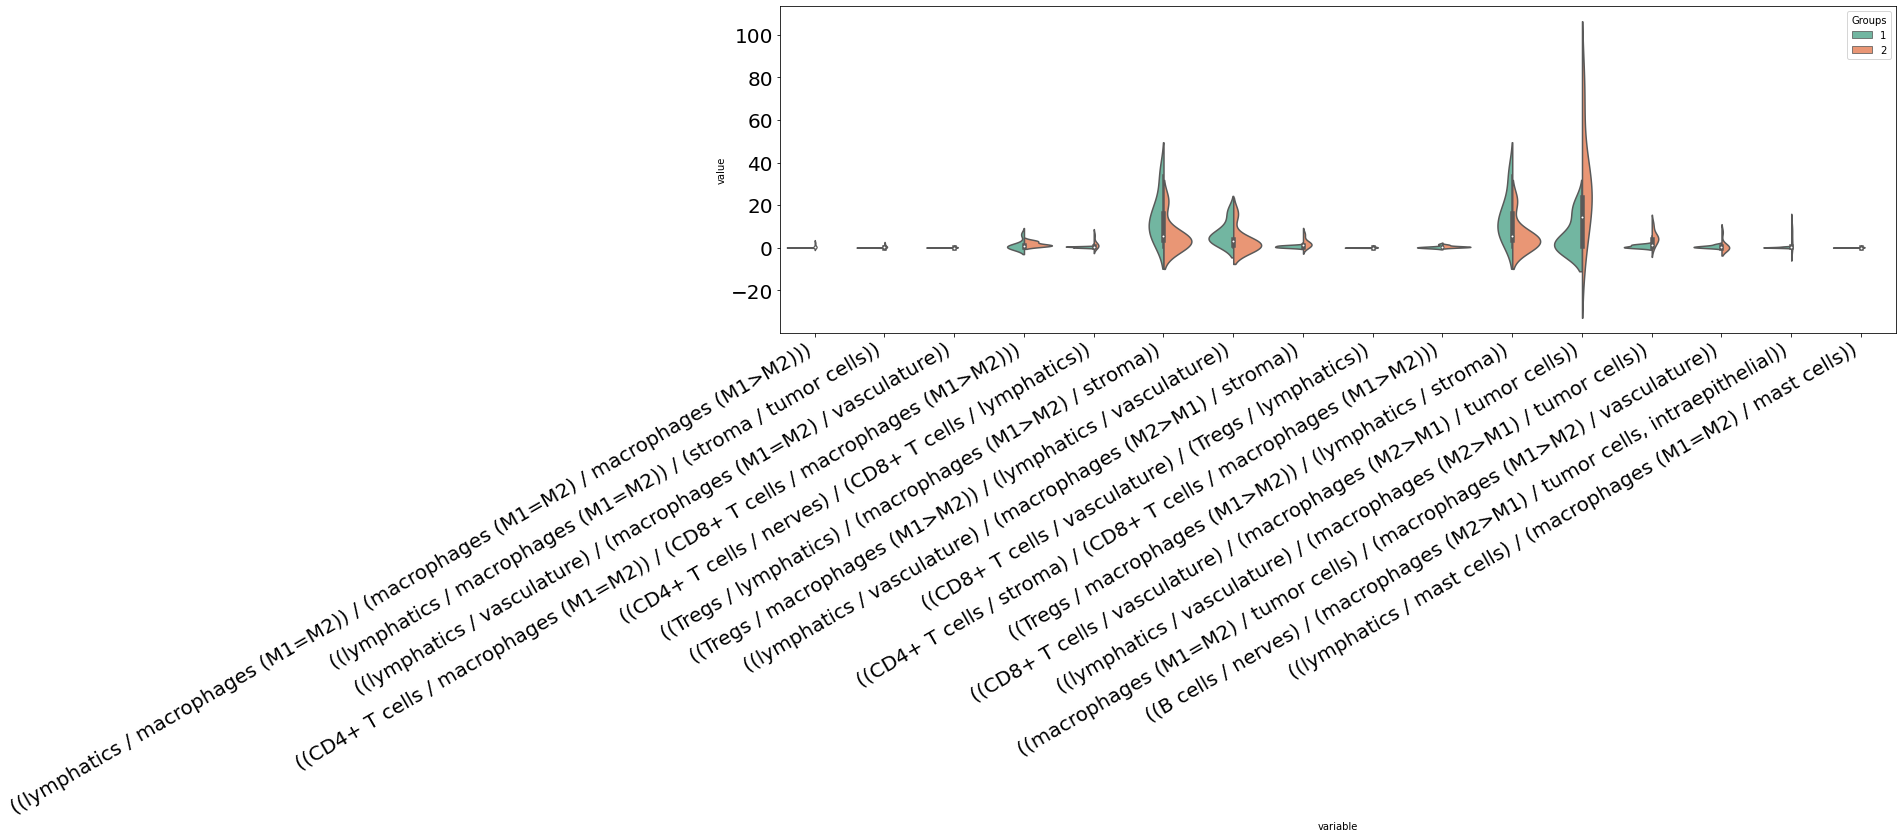

In [21]:
exclude_vars = [
    '((Langerhans cells / nerves) / (mast cells / tumor cells))',
    '((Tregs / lymphatics) / (lymphatics / vasculature))',
    '((Tregs / nerves) / (Tregs / tumor cells))',
    '((CD8+ T cells / nerves) / (CD8+ T cells / tumor cells))',
]
fig, ax = mosna.plot_distrib_groups(
    prop_types_comp, 
    groups_labels='Groups',
    groups=[1, 2], 
    pval_data=pvals, 
    pval_col='pval', 
    max_cols=20, 
    multi_ind_to_col=True,
    exclude_vars=exclude_vars,
    )

### Heatmap of cell types proportions

In [24]:
from importlib import reload
reload(mosna)

<module 'mosna.mosna' from '/home/acoullom/Projects/mosna/mosna/mosna.py'>

/home/acoullom/Projects/mosna/mosna/mosna.py:1270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[groups_labels], inplace=True)


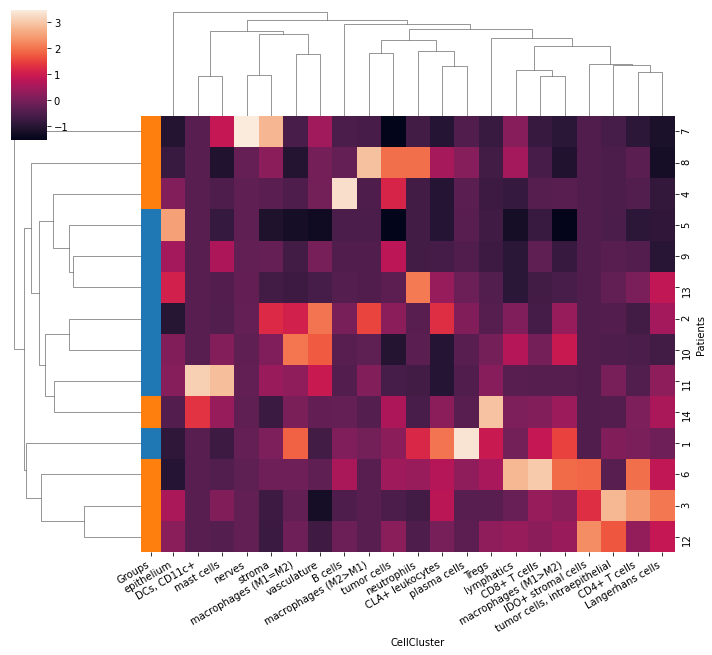

In [22]:
g = mosna.plot_heatmap(prop_types.reset_index(), obs_labels='Patients', groups_labels='Groups', groups=[1, 2])

There is no clear separation of patients into their respective groups from their proportions of cell types scaled across patients.

In [23]:
# we need to clean-up data for further analyses and visualizations
prop_types_comp_cleaned, select_finite = mosna.clean_data(
    prop_types_comp, 
    method='mixed',
    thresh=0.9,
    )

There are 131834 non finite values
Imputing data


/home/acoullom/Projects/mosna/mosna/mosna.py:1270: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=[groups_labels], inplace=True)


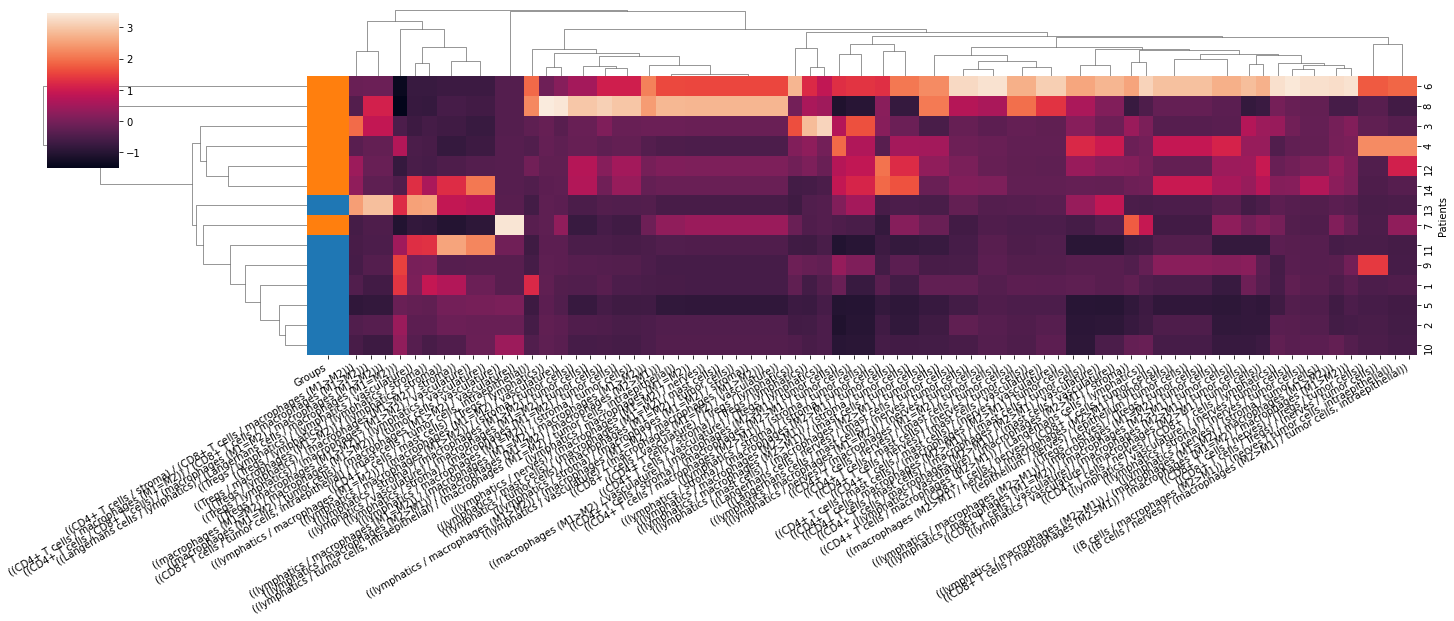

In [24]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index
# or to select only 20 variables:
# best_pval_names = pvals.head(20).index
mosna.plot_heatmap(
    prop_types_comp_cleaned[best_pval_names].reset_index(), 
    obs_labels='Patients', 
    groups_labels='Groups', 
    groups=[1, 2],
    figsize=(20, 12),
    )

By selecting the variables with p-values under 5%, although their corresponding corrected p-values are not significant, we can notice a much better separation between patients groups.

#### Stepwise logistic regression

In [25]:
best_pval_names = pvals.loc[pvals['pval'] < 0.05, :].index.tolist()
model, included = mosna.stepwise_regression(X=prop_types_comp_cleaned, y_name='Groups', y_values=[1, 2], col_names=best_pval_names, verbose=True)

Add  ((Langerhans cells / lymphatics) / (Langerhans cells / macrophages (M1=M2))) with p-value 0.00186317
Add  ((macrophages (M1>M2) / vasculature) / (macrophages (M2>M1) / tumor cells)) with p-value 0.000234876
Add  ((CD8+ T cells / macrophages (M2>M1)) / (macrophages (M1=M2) / macrophages (M1>M2))) with p-value 0.00216709


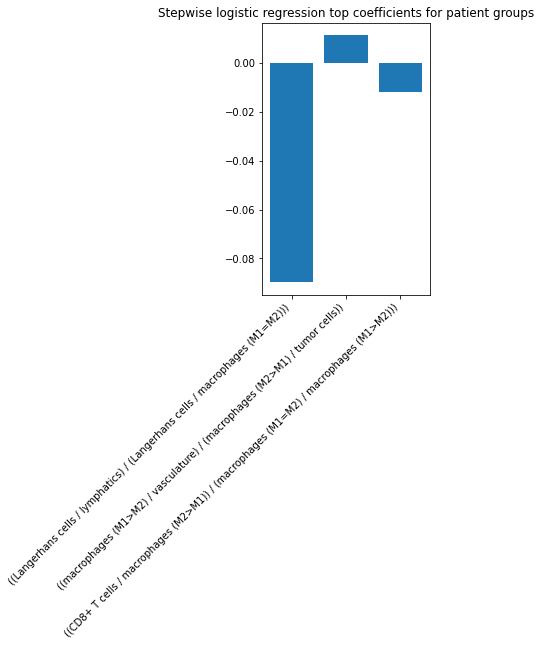

In [26]:
# plot the model's coefficients
coefs = model.params[1:] # skip intercept
nb_coefs = min(coefs.size, 20)
if nb_coefs > 0:
    fig, ax = plt.subplots(figsize=(nb_coefs,5))
    ax.bar(coefs.index, coefs)
    plt.xticks(rotation=45, ha='right');
    title = f"Stepwise logistic regression top coefficients for patient groups"
    plt.title(title)

#### Risk ratios

#### Survival analysis

### Marker-positive cells proportions

In [ ]:
def highlight_under(s, thresh=0.05, color='darkorange'):
    '''
    highlight values that are under a threshold
    '''
    is_under = s <= thresh
    attr = 'background-color: {}'.format(color)
    return [attr if v else '' for v in is_under]

We have seen that cell types proportions don't explain response of patient to therapy. But maybe interactions between cell types play a role in response?  
To answer this question we will look at the *mixing matrix* and *assortativity* of tissue networks.  

### Cell types interactions

We compute cell types interactions per sample to aggregate latter per patient or condition.

In [ ]:
grouping = 'FileName'
n_shuffle = 500
start = time()
net_stats = mosna.batch_assort_mixmat(nodes_all, edges_all, 
                                attributes=attribute_uniq, 
                                groups=obj[grouping], 
                                n_shuffle=n_shuffle,
                                parallel='max',
                                memory_limit='100GB')
end = time()
duration = end - start
print(f"Assortativity took {duration}s for n_suffle {n_shuffle}")

In [29]:
net_stats.index = net_stats['id']
net_stats.index.name = grouping
net_stats.drop(columns=['id'], inplace=True)
net_stats

id # total % B cells % CD4+ T cells % CD8+ T cells % CLA+ leukocytes  \
0   reg001    1301  0.017679       0.012298       0.082244          0.009224   
1   reg002    2324  0.004733        0.01463       0.052496          0.003442   
2   reg006     603   0.00995       0.004975       0.008292          0.004975   
3   reg035    2053  0.000487       0.007306       0.014613          0.000974   
4   reg036     618  0.001618       0.006472       0.033981               0.0   
..     ...     ...       ...            ...            ...               ...   
64  reg005     112       0.0            0.0            0.0               0.0   
65  reg018     458       0.0            0.0            0.0               0.0   
66  reg027     249       0.0       0.004016            0.0               0.0   
67  reg026     257       0.0            0.0            0.0               0.0   
68  reg025     144       0.0            0.0            0.0               0.0   

   % DCs, CD11c+ % epithelium % IDO+ stromal cells % Langerhans cells  ...  \
0            0.0     0.069178                  0.0            0.01691  ...   
1            0.0     0.009466                  0.0           0.008606  ...   
2            0.0     0.006633                  0.0             0.0199  ...   
3            0.0     0.500731                  0.0           0.004384  ...   
4            0.0     0.021036                  0.0           0.003236  ...   
..           ...          ...                  ...                ...  ...   
64           0.0     0.017857                  0.0                0.0  ...   
65           0.0     0.884279                  0.0           0.004367  ...   
66           0.0     0.088353                  0.0                0.0  ...   
67           0.0          0.0                  0.0           0.003891  ...   
68           0.0          0.0                  0.0                0.0  ...   

   vasculature - macrophages (M2>M1) Z vasculature - mast cells Z  \
0                            -1.573321                  -0.548763   
1                            -2.415007                  -0.816497   
2                            -2.488803                  -0.423929   
3                            -1.067955                  -1.971728   
4                            -1.624943                  -2.088322   
..                                 ...                        ...   
64                            -1.26781                  -0.480384   
65                                 NaN                  -0.292233   
66                           -0.477471                    -0.9942   
67                                 NaN                  -1.253539   
68                                 NaN                        NaN   

   vasculature - nerves Z vasculature - neutrophils Z  \
0               -1.006743                   -1.786782   
1                -1.52254                    -1.03926   
2               -0.744377                   -0.354005   
3               -0.678315                         NaN   
4               -1.818137                         NaN   
..                    ...                         ...   
64                    NaN                         NaN   
65              -0.358621                         NaN   
66              -0.954455                   -0.404535   
67              -5.190174                         NaN   
68              -1.647621                         NaN   

   vasculature - plasma cells Z vasculature - stroma Z vasculature - Tregs Z  \
0                     -2.562116               -4.77787             -3.236063   
1                     -2.699913              -5.110771             -4.530662   
2                     -0.582428              -3.713563             -1.154683   
3                           NaN              -5.653702             -1.309551   
4                           NaN              -7.794368             -0.874386   
..                          ...                    ...                   ...   
64                          NaN     

In [30]:
save_dir = processed_dir / "assortativity"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

filename = f'network_interactions_stats_grouping-{grouping}_n_shuffle-{n_shuffle}.csv'
net_stats.to_csv(save_dir / filename)

### Marker-positive cells interactions

### Cellular neighborhoods